In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsc
import matplotlib.pyplot as plt
from functools import partial
import sympy as sp
import scipy.stats as stats

key = jr.PRNGKey(4)

def generate_data(key, n_data):
    x_key, noise_key = jr.split(key)
    weight = 4.0
    bias = 1.0
    x = jr.uniform(x_key, (n_data, ))
    x = jnp.sort(x)
    noise = jr.normal(noise_key, x.shape)
    y = weight * x + bias + noise
    return x, y


n_data = 100
x, y = generate_data(key, n_data)
X = jnp.stack((x, jnp.ones_like(x))).T


In [9]:
@partial(jax.vmap, in_axes=(0))
def expm(x):
    return jsc.linalg.expm(x)


@jax.jit
def loss(w, X, y):
    return 0.5 * jnp.mean((X @ w - y.reshape((-1, 1)))**2)


def update(carry, _):
    w_gd, learning_rate = carry
    grad = jax.grad(loss)(w_gd, X, y)
    w_gd = w_gd - learning_rate * grad
    return (w_gd, learning_rate), w_gd


def fit_convergance_line(error, learning_rates):
    A = jnp.column_stack(
        (jnp.log(jnp.array(learning_rates)), jnp.ones((len(learning_rates), ))))
    log_error = jnp.log(jnp.array(error))
    coefficients, _, _, _ = jnp.linalg.lstsq(A, log_error)
    return coefficients

@jax.jit
def max_error(x, y):
    return jnp.max((jnp.abs(jnp.linalg.norm(x, axis=1) - jnp.linalg.norm(y, axis=1))))


(1.0273935794830322, 2.006936550140381)

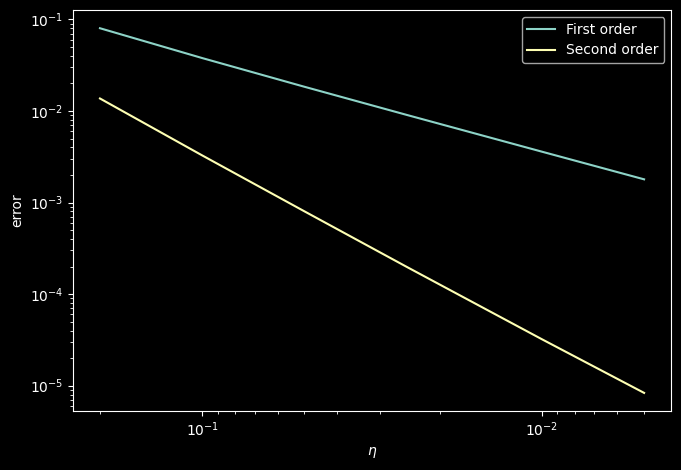

In [26]:
n_variables = 2
w_0 = jnp.ones((n_variables, 1))
M = X.T @ X
w_star = jnp.linalg.solve(M, X.T @ y).reshape((-1, 1))

first_order_error = []
second_order_error = []
learning_rates = [0.2, 0.1, 0.05, 0.025, 0.01, 0.005]
final_time = 1
results = []

for learning_rate in learning_rates:
    max_iter = int(final_time / learning_rate)

    # Analytical solution to the modified equation
    t = jnp.linspace(0, final_time,
                     max_iter+1).reshape((-1, 1, 1))
    w_first_order = (expm(-1/n_data * M * t) @
                     (w_0 - w_star) + w_star).reshape((-1, n_variables))
    w_second_order = (expm(-1/n_data * (M @ (jnp.eye(n_variables) + learning_rate/(2*n_data) * M)) * t) @
                      (w_0 - w_star) + w_star).reshape((-1, n_variables))

    # Gradient descent iterates
    _, iterates = jax.lax.scan(
        update, (w_0, learning_rate), jnp.arange(0, max_iter))

    w_gd = jnp.concatenate(
        (w_0.reshape((1, n_variables, 1)), iterates)).squeeze()
    first_order_error.append(max_error(w_gd, w_first_order))
    second_order_error.append(max_error(w_gd, w_second_order))

fig, ax = plt.subplots()
ax.plot(learning_rates, first_order_error, label='First order')
ax.plot(learning_rates, second_order_error, label='Second order')
ax.invert_xaxis()
ax.set_xlabel('$\eta$')
ax.set_ylabel('error')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()
fig.set_figwidth(7)
# plt.
# plt.savefig()
fig.savefig('../seminar_talk/plots/linear_regression_error.pdf')
first_order, _ = fit_convergance_line(first_order_error, learning_rates)
second_order, _ = fit_convergance_line(second_order_error, learning_rates)
first_order.item(), second_order.item()


# Gradient descent

In [13]:
key, subkey = jr.split(key)
weight, bias = jr.normal(subkey, (2,))
weight_0 = weight.copy()
bias_0 = bias.copy()

In [14]:
@jax.jit
def loss(weight, bias, x, y): return jnp.square(weight * x + bias - y).sum(0)

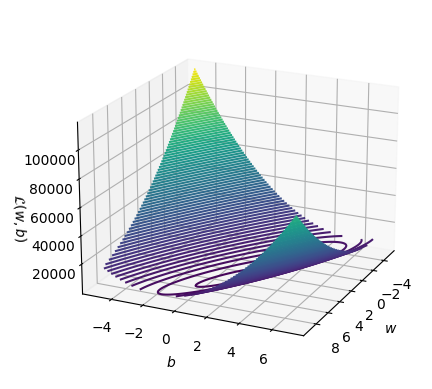

In [15]:
import numpy as np
fig = plt.figure()
ax = plt.axes(projection='3d')
weights_plt = np.linspace(-5, 9, 100)
biases_plt = np.linspace(-5, 7, 100)
W, B = np.meshgrid(weights_plt, biases_plt)
# L = (W * x + B - y) **
# L.shape
f = jnp.sum(((W[None,:,:] * x[:,None,None] + B[None, :, :] - y[:, None, None]) ** 2), 0)
ax.contour3D(W, B, f, 90);
ax.set_xlabel('$w$')
ax.set_ylabel('$b$')
ax.set_zlabel('$\mathcal{L} (w,b)$')
ax.view_init(20, 25)
# L
# fig.tight_layout()
plt.savefig('../seminar_talk/plots/quadratic_loss.pdf',bbox_inches='tight')

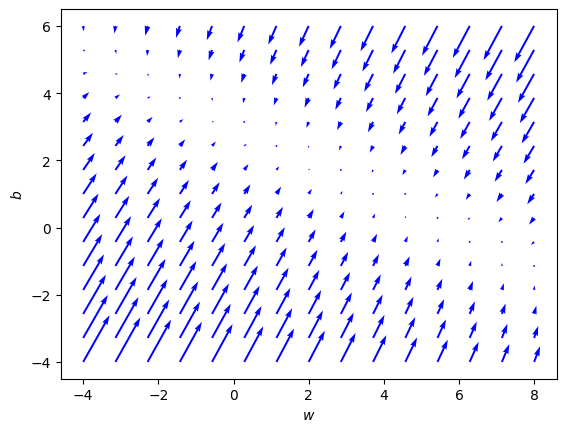

In [16]:
weights_plt = np.linspace(-4, 8, 15)
biases_plt = np.linspace(-4, 6, 15)
W, B = np.meshgrid(weights_plt, biases_plt)


def batched_loss(weight, bias, x, y): return jnp.square(
    weight * x + bias - y).sum(0)


@partial(jax.jit)
def grid_gradients(W, B, x, y):
    return jax.vmap(jax.vmap(jax.grad(
        batched_loss, argnums=(0, 1)), in_axes=(0, 0, None, None)), in_axes=(0, 0, None, None))(W, B, x, y)


dW, dB = grid_gradients(W, B, x, y)
# plt_W = np.asarray(W)
# plt_dW = np.asarray(dW)
# plt_B = np.asarray(B)
# plt_dB = np.asarray(dB)
plt.quiver(W, B, -dW, -dB, color='b')
plt.xlabel('$w$')
plt.ylabel('$b$')
# plt.show()
# plt_dB.shape
plt.savefig('../seminar_talk/plots/gradients.pdf')

Weight: 3.136, bias: 1.442
Loss: 1017.139892578125
Weight: 3.754, bias: 1.114
Loss: 985.7225341796875
Weight: 3.758, bias: 1.112
Loss: 985.7213745117188
Weight: 3.758, bias: 1.112
Loss: 985.7213745117188


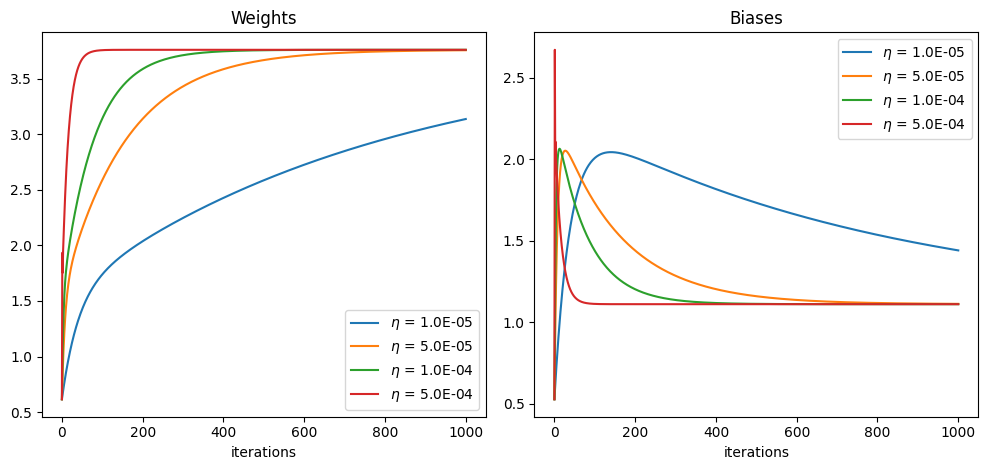

In [24]:
learning_rates = [0.00001, 0.00005, 0.0001, 0.0005]
max_iter = 1000
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
for learning_rate in learning_rates:
    weight = weight_0
    bias = bias_0
    weights = [weight]
    biases = [bias]
    for i in range(max_iter):
        dweight, dbias = jax.grad(loss, argnums=(0, 1))(weight, bias, x, y)
        weight += - learning_rate * dweight
        bias += - learning_rate * dbias
        weights.append(weight)
        biases.append(bias)
    weights = jnp.array(weights)
    biases = jnp.array(biases)
    print(f'Weight: {weight:.3f}, bias: {bias:.3f}')
    print(f'Loss: {loss(weight, bias, x, y)}')
    ax[0].plot(jnp.arange(0, max_iter+1), weights,
               label=f'$\eta$ = {learning_rate:.1E}')
    ax[0].set_title('Weights')
    ax[1].plot(jnp.arange(0, max_iter+1), biases,
               label=f'$\eta$ = {learning_rate:.1E}')
    ax[1].set_title('Biases')
    ax[0].set_xlabel('iterations')
    ax[1].set_xlabel('iterations')
    ax[0].legend()
    ax[1].legend()
fig.tight_layout()
plt.savefig('../seminar_talk/plots/learning_rates.pdf',bbox_inches='tight')

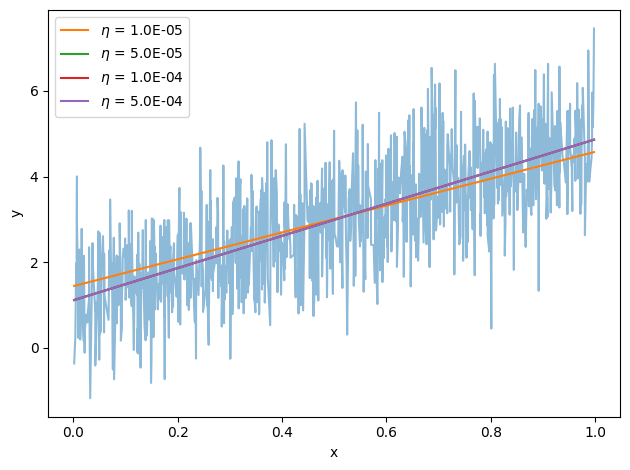

In [26]:
learning_rates = [0.00001, 0.00005, 0.0001, 0.0005]
max_iter = 1000

plt.plot(x, y, alpha = .5)
for learning_rate in learning_rates:
    weight = weight_0
    bias = bias_0
    weights = [weight]
    biases = [bias]
    for i in range(max_iter):
        dweight, dbias = jax.grad(loss, argnums=(0, 1))(weight, bias, x, y)
        weight += - learning_rate * dweight
        bias += - learning_rate * dbias
        weights.append(weight)
        biases.append(bias)
    weights = jnp.array(weights)
    biases = jnp.array(biases)

    y_hat = weight * x + bias

    plt.plot(x, y_hat, label=f'$\eta$ = {learning_rate:.1E}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.savefig('../seminar_talk/plots/linear_fit.pdf',bbox_inches='tight')

Weight: nan, bias: nan
Loss: nan


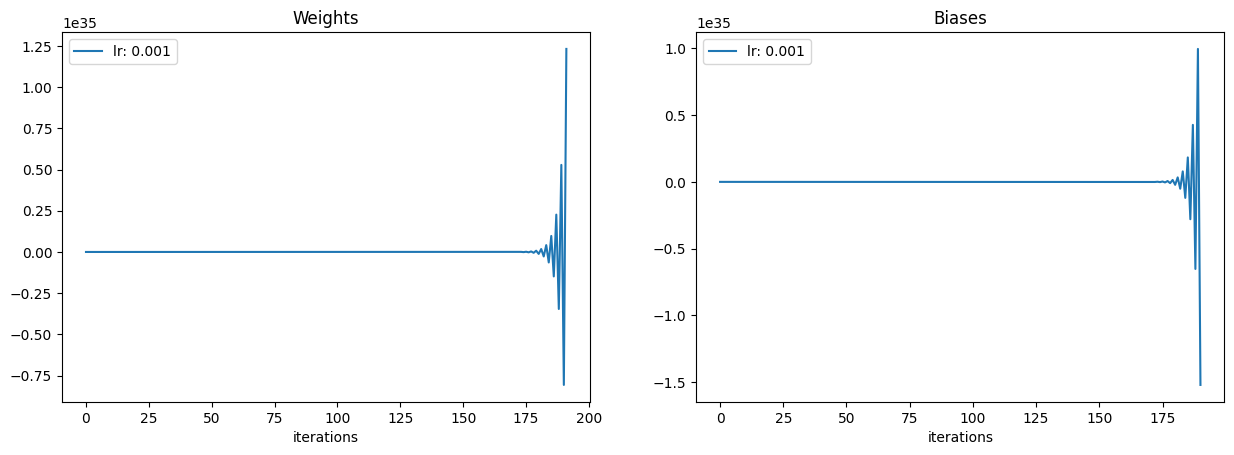

In [30]:
# Large learning rate
learning_rates = [0.001]
max_iter = 1000
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(15)
for learning_rate in learning_rates:
    weight = weight_0
    bias = bias_0
    weights = [weight]
    biases = [bias]
    for i in range(max_iter):
        dweight, dbias = jax.grad(loss, argnums=(0, 1))(weight, bias, x, y)
        weight += - learning_rate * dweight
        bias += - learning_rate * dbias
        weights.append(weight)
        biases.append(bias)
    weights = jnp.array(weights)
    biases = jnp.array(biases)
    print(f'Weight: {weight:.3f}, bias: {bias:.3f}')
    print(f'Loss: {loss(weight, bias, x, y)}')
    ax[0].plot(jnp.arange(0, max_iter+1), weights,
               label=f'lr: {learning_rate}')
    ax[0].set_title('Weights')
    ax[1].plot(jnp.arange(0, max_iter+1), biases,
               label=f'lr: {learning_rate}')
    ax[1].set_title('Biases')
    ax[0].set_xlabel('iterations')
    ax[1].set_xlabel('iterations')
    ax[0].legend()
    ax[1].legend()
plt.savefig('../seminar_talk/plots/large_learning_rate.pdf')


Weight: 3.136, bias: 1.442
Loss: 1017.139892578125
Weight: 3.754, bias: 1.114
Loss: 985.7225341796875
Weight: 3.758, bias: 1.112
Loss: 985.7213745117188
Weight: 3.758, bias: 1.112
Loss: 985.7213745117188


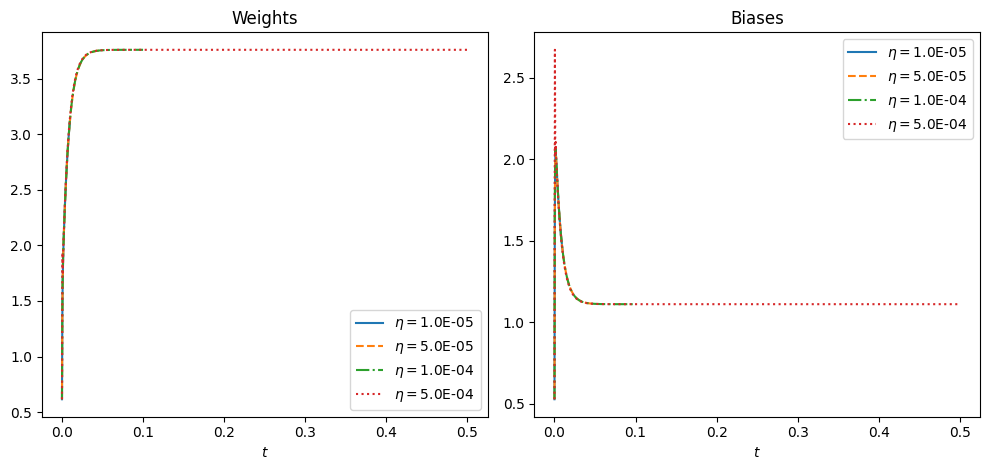

In [27]:
# Scaled learning rates
learning_rates = [0.00001, 0.00005, 0.0001, 0.0005]
line_styles = ['-', '--', '-.', ':']
max_iter = 1000
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
for line_style, learning_rate in zip(line_styles, learning_rates):
    weight = weight_0
    bias = bias_0
    weights = [weight]
    biases = [bias]
    for i in range(max_iter):
        dweight, dbias = jax.grad(loss, argnums=(0, 1))(weight, bias, x, y)
        weight += - learning_rate * dweight
        bias += - learning_rate * dbias
        weights.append(weight)
        biases.append(bias)
    weights = jnp.array(weights)
    biases = jnp.array(biases)
    print(f'Weight: {weight:.3f}, bias: {bias:.3f}')
    print(f'Loss: {loss(weight, bias, x, y)}')
    t = jnp.linspace(0, max_iter * learning_rate, max_iter + 1)
    ax[0].plot(t, weights, line_style,
               label=f'$\eta=${learning_rate:.1E}')
    ax[0].set_title('Weights')
    ax[1].plot(t, biases, line_style,
               label=f'$\eta=${learning_rate:.1E}')
    ax[1].set_title('Biases')
    ax[0].set_xlabel('$t$')
    ax[1].set_xlabel('$t$')
    ax[0].legend()
    ax[1].legend()
fig.tight_layout()
plt.savefig('../seminar_talk/plots/scaled_weights_biases.pdf',
            bbox_inches='tight')


# Observations

The parameters follow a smooth trajectory.
Update rule: $X_{k+1} = X_k - \eta \nabla f(X_k), \quad X_0 = x$.

This is Euler's method for the system of ODEs: $X'(t) = - \nabla f(X(t)), \quad X(0) = x$.

In the above example we have: $$f(w, b) = \sum_{i=1}^n (w x_i + b - y_i)^2$$.
$$\nabla_w f(w,b) = \sum_{i=1}^n 2 (w x_i + b - y_i) x_i = 2\left(\sum_{i=1}^n x_i^2 \right) w + 2\left(\sum_{i=1}^n x_i \right) b - 2 \sum_{i=1}^n x_i y_i$$
$$\nabla_b f(w,b) = \sum_{i=1}^n 2 (w x_i + b - y_i) = 2\left(\sum_{i=1}^n x_i \right) w + 2 n b - 2 \sum_{i=1}^n y_i$$


In [100]:
# Analytical solution of the ODE system
x_sum_squared = float((x ** 2).sum())
x_sum = float((x).sum())
x_y_sum = float((x * y).sum())
y_sum = float((y).sum())

w_0 = float(weight_0)
b_0 = float(bias_0)

t = sp.symbols('t')
w = sp.Function('w')
b = sp.Function('b')
solution = sp.dsolve([w(t).diff(t) + 2 * x_sum_squared * w(t) + 2 * x_sum * b(t) - 2 *
                      x_y_sum, b(t).diff(t) + 2 * x_sum * w(t) + 2 * n_data * b(t) - 2 * y_sum], ics={w(0): w_0, b(0): b_0})
solution

[Eq(w(t), 3.9290397752782 - 0.953230645569722*exp(-2539.02662122444*t) - 2.3590588297779*exp(-128.184377310721*t)),
 Eq(b(t), 1.03872461893729 - 1.77633315825248*exp(-2539.02662122444*t) + 1.26593773290726*exp(-128.184377310721*t))]

In [101]:
w_t = sp.lambdify([t], solution[0].rhs)
b_t = sp.lambdify([t], solution[1].rhs)
w_t(0), w_0, b_t(0), b_0

(0.6167502999305778,
 0.6167502999305725,
 0.5283291935920702,
 0.5283291935920715)

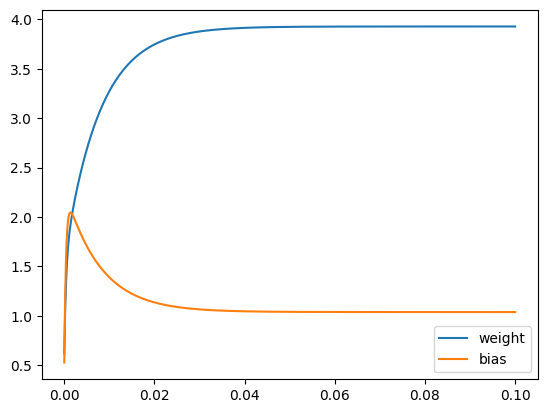

In [103]:
learning_rate = 0.0001
t = jnp.linspace(0, max_iter * learning_rate, max_iter)
plt.plot(t, w_t(t), label = 'weight')
plt.plot(t, b_t(t), label='bias')
plt.legend();

In [28]:
# SGD
@jax.jit
@partial(jax.vmap, in_axes=(0, 0, 0, 0, None))
def update(weight, bias, x_batch, y_batch, learning_rate):
    value, (dweight, dbias) = jax.value_and_grad(loss, argnums=(0, 1))(
        weight, bias, x_batch, y_batch)
    weight += - learning_rate * dweight
    bias += - learning_rate * dbias
    return value, weight, bias


def sgd_run(key, learning_rate, batch_size, max_iter):
    repetitions = 10000
    
    weight = jnp.repeat(weight_0[None, None], repetitions, axis=0)
    bias = jnp.repeat(bias_0[None, None], repetitions, axis=0)
    weights = [weight]
    biases = [bias]
    values = []
    for i in range(max_iter):
        key, sample_key = jr.split(key)
        ix = jr.choice(sample_key, jnp.arange(
            0, x.shape[0]), (repetitions, batch_size))
        value, weight, bias = update(weight, bias, x[ix], y[ix], learning_rate)
        weights.append(weight)
        biases.append(bias)
        values.append(value)
    return jnp.array(values), jnp.array(weights).squeeze(), jnp.array(biases).squeeze()

max_iter = 1000
learning_rate = 0.1
batch_size = 1
values, weights, biases = sgd_run(key, learning_rate, batch_size, max_iter)

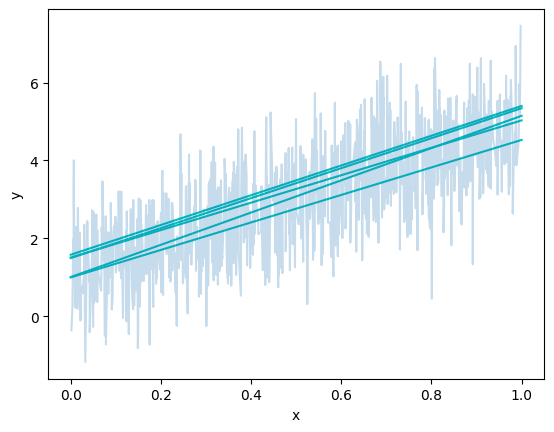

In [29]:
x_plt = jnp.linspace(0,1,100)
y_hat = weights[-1,:]* x_plt[:, None] + biases[-1,:]
for i in range(0,y_hat.shape[1],2000):
    plt.plot(x_plt, y_hat[:,i], 'c')
plt.plot(x,y,alpha=0.25)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('../seminar_talk/plots/sgd_linear_fit.pdf')

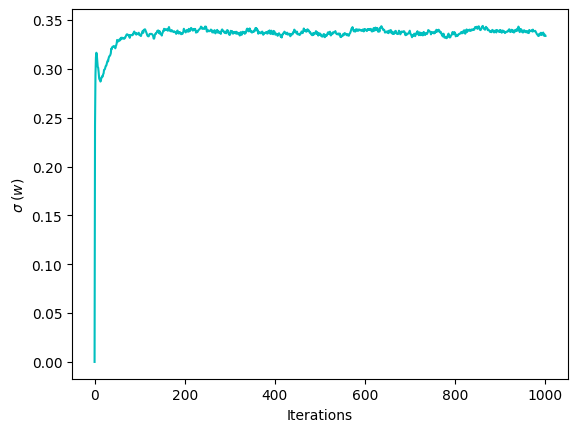

In [30]:
std = jnp.std(weights, 1)
plt.plot(std, 'c')
plt.xlabel('Iterations')
plt.ylabel('$\sigma\;(w)$')
plt.savefig('../seminar_talk/plots/sgd_std.pdf')

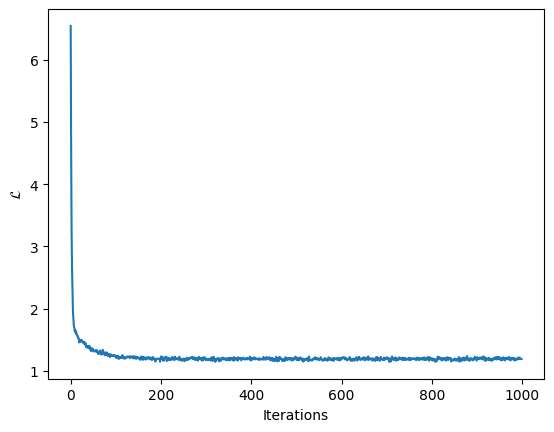

In [108]:
plt.plot(values.mean(1))
plt.xlabel('Iterations')
plt.ylabel('$\mathcal{L}$');

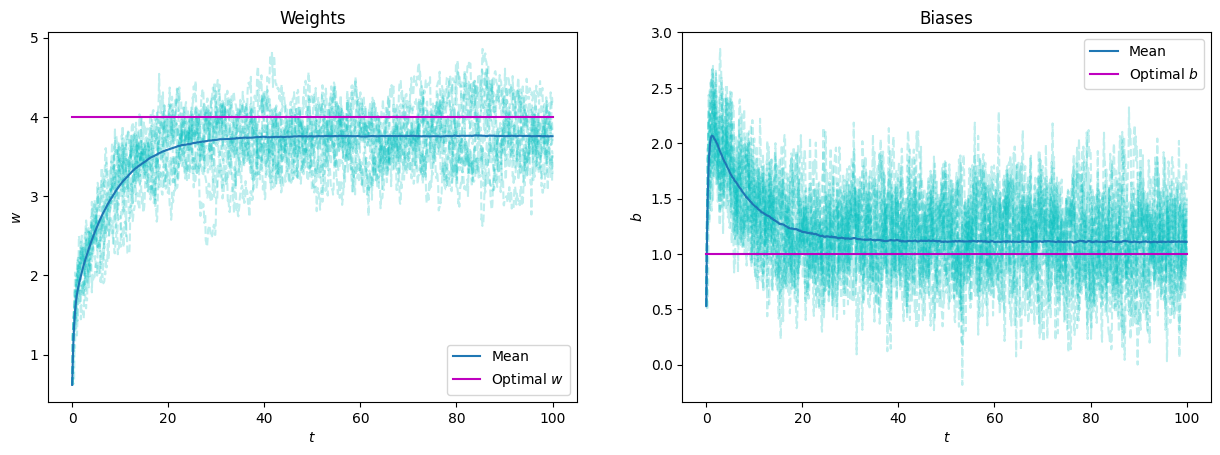

In [31]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(15)
t = jnp.linspace(0, max_iter * learning_rate,
                 max_iter+1)
for i in range(0, weights.shape[1],1000):
    axes[0].plot(t, weights[:, i], 'c--', alpha=0.25)
    axes[1].plot(t, biases[:, i], 'c--', alpha=0.25)
axes[0].plot(jnp.linspace(0, max_iter * learning_rate, max_iter+1),
             weights[:, :].mean(1), label='Mean')
axes[1].plot(jnp.linspace(0, max_iter * learning_rate, max_iter+1),
             biases[:, :].mean(1), label='Mean')
axes[0].plot(t, jnp.ones_like(t) * 4.0, 'm', label='Optimal $w$')
axes[1].plot(t, jnp.ones_like(t) * 1.0, 'm', label='Optimal $b$')
axes[0].set_title('Weights')
axes[1].set_title('Biases')
axes[0].set_ylabel('$w$')
axes[1].set_ylabel('$b$')
for axis in axes:
    axis.set_xlabel('$t$')
axes[0].legend();
axes[1].legend();
plt.savefig('../seminar_talk/plots/sgd_weight_bias.pdf')

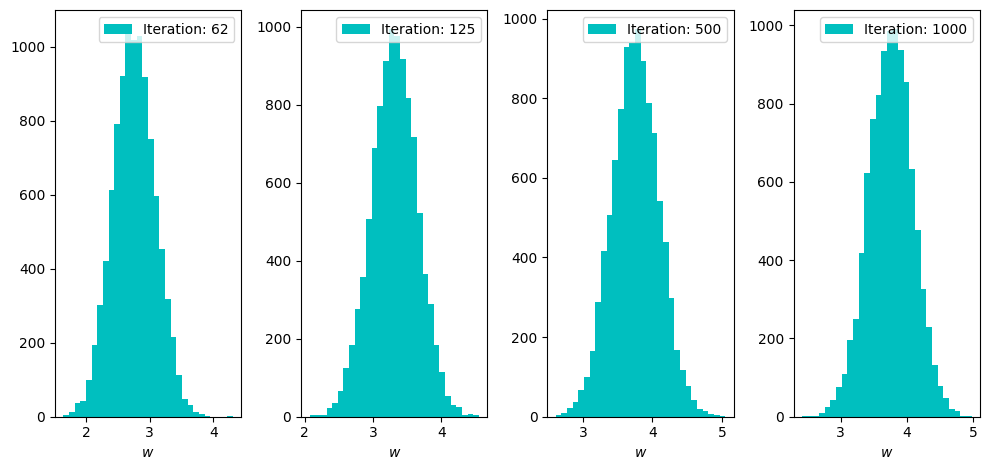

In [34]:
max_iter = 1000
learning_rate = 0.1
batch_size = 1
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(10)
iterations = [max_iter // 16, max_iter // 8, max_iter // 2, max_iter]
_, weights, biases = sgd_run(key, learning_rate, batch_size, max_iter)
for i, iteration in enumerate(iterations):
    axes[i].hist(weights[iteration, :], 30, color='c',
                 label=f'Iteration: {iteration}')
    axes[i].set_xlabel('$w$')
    axes[i].legend()
fig.tight_layout()
plt.savefig('../seminar_talk/plots/sgd_weight_histogram.pdf',
            bbox_inches='tight')


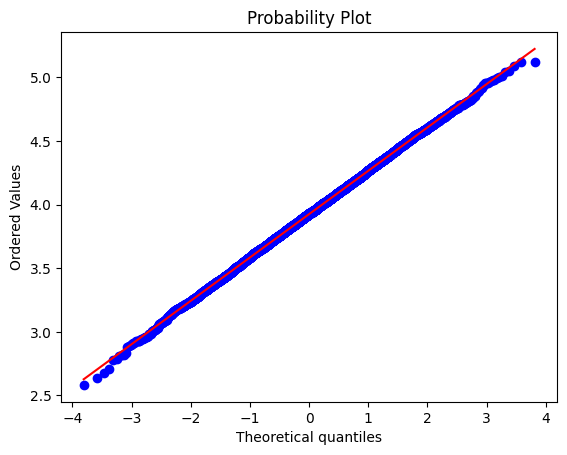

In [111]:
measurements = weights[-1,:]
stats.probplot(measurements, dist="norm", plot=plt);
plt.savefig('../seminar_talk/plots/sgd_weight_qq.pdf')
